## Data Cleaning Stage

### Data reading

This notebook brings uses the scripts read_data_features.py and read_data_genre_track.py to arrive at a cleaned dataset with ready to use features and labels.

The following is 'read_data_genre_track.py'. 

In [80]:
import numpy as np
import pandas as pd

In [81]:
# import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

#matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [82]:
metadata_path = 'fma_metadata'

In [83]:
## Read genre information
genres = pd.read_csv(metadata_path+'\\genres.csv')

In [84]:
genre_grps = genres.groupby('parent')


In [85]:
genre_id_root = genre_grps.get_group(0)['genre_id'] # Extract the parent groups
genre_id_name = genre_grps.get_group(0)['title']
main_label_dict = dict(zip(list(genre_id_root),list(genre_id_name)))

In [86]:
main_label_dict

{2: 'International',
 3: 'Blues',
 4: 'Jazz',
 5: 'Classical',
 8: 'Old-Time / Historic',
 9: 'Country',
 10: 'Pop',
 12: 'Rock',
 13: 'Easy Listening',
 14: 'Soul-RnB',
 15: 'Electronic',
 17: 'Folk',
 20: 'Spoken',
 21: 'Hip-Hop',
 38: 'Experimental',
 1235: 'Instrumental'}

In [87]:
## Read track information
fields = ['track']
tracks = pd.read_csv(metadata_path+'\\tracks_mod.csv',nrows=85000)
tracks.head()

,track_id,genres,genres_all
0,2,[21],[21]
1,3,[21],[21]
2,5,[21],[21]
3,10,[10],[10]
4,20,"[76, 103]","[17, 10, 76, 103]"


In [88]:
tracks = tracks.dropna()

In [89]:
tgen = list(tracks['genres'])
#print(tgen)

In [90]:
tgen = [t.replace('[','') for t in tgen]
tgen = [t.replace(']','') for t in tgen]
tgen = [t.replace(' ','') for t in tgen]
#print(tgen)

In [91]:
for k in range(len(tgen)):
    if(len(tgen[k])!=0):
        tgen[k] = [i for i in map(int, tgen[k].split(','))]
    else:
        tgen[k]=[]
#print(tgen)

In [92]:
tracks['genres']=tgen

In [93]:
tracks.head()

,track_id,genres,genres_all
0,2,[21],[21]
1,3,[21],[21]
2,5,[21],[21]
3,10,[10],[10]
4,20,"[76, 103]","[17, 10, 76, 103]"


In [94]:
print(len(tgen))
#print(tracks.index)

84991


### Extracting relevant tracks and labels

In [95]:
## Match the tracks to the genre data: Create dictionary with genre label as key
genre_dict = {}
for i in range(len(tgen)): # for every track (tgen is a list of lists of genres corresponding to every track)
    if i in tracks.index:  
        ti = tracks['track_id'][i] # ti stores the track id corresponding to the index
        if 1<=len(tgen[i])<=1: # new condition that checks if t has just one genre and only then proceeds
            for k in tgen[i]: # k iterates through list of genres of current track
                if k is not None:
                    if (k in genre_dict.keys()): # if new genre is in the keys of genre_dict
                        genre_dict[k]+=[ti] # append current track id to list of all track ids
                    else:
                        genre_dict.update({k:[ti]}) # if k is a new key, then add new element to dictionary with ti as value

In [96]:
genre_dict[4][0]

144

In [97]:
## Total number of samples for the different root genres
for q in genre_id_root:
    print(q,len(genre_dict[q]))

2 119
3 101
4 320
5 731
8 543
9 16
10 505
12 1717
13 3
14 15
15 2221
17 1205
20 17
21 2363
38 1233
1235 199


Based on the above, the genres with sufficient data is selected for training.

In [98]:
#genre_set = [4,5,8,10,12,15,17,21,38]
#genre_set = [17,15,12,21,38]
#genre_set = [8,5,12,15,17,21,38]
# genre_set = [4,5,10,12,15,17,21,38]
#genre_set = [10,5,12,15,17,21,38]
# genre_set = [4,5,10,15,17,21,38] # removed rock
genre_set = [4, 5,10,12,15,17,21,38]


num_tracks = 320
tr_len = 300 # Training length per class
test_len = 20 # Testing length per class

The code below selects the unique selection of 932 tracks from this list, with no repetitionof tracks

In [99]:
track_list = genre_dict[genre_set[0]]
for k in genre_set[1:]:
    t1 = genre_dict[k]
    i = 0
    while i<num_tracks:
        t2 = t1.pop()
        if t2 not in track_list:
            track_list.append(t2)
            i+=1
            
len(set(track_list))/len(genre_set)

320.0

Now we create the corresponding list of labels for this list.

In [100]:
label_list = [t for t in genre_set for i in range(num_tracks)]
len(label_list)/9

284.44444444444446

### Creating the training and testing data

Now we create the training and testing set partitions based on track index

In [101]:
tr_set = track_list[0:tr_len]
tr_lbl = label_list[0:tr_len]
test_set = track_list[tr_len:num_tracks]
test_lbl = label_list[tr_len:num_tracks]

print(len(tr_set),len(tr_lbl),len(test_set),len(test_lbl))

for k in range(1,len(genre_set)):
    tr_set+=track_list[num_tracks*k:(num_tracks*k)+tr_len]
    test_set+=track_list[num_tracks*k+tr_len:num_tracks*(k+1)]
    tr_lbl+=label_list[num_tracks*k:(num_tracks*k)+tr_len]
    test_lbl+=label_list[num_tracks*k+tr_len:num_tracks*(k+1)]

print(len(tr_set)/len(genre_set))
print(len(tr_lbl)/len(genre_set))
print(len(test_set)/len(genre_set))
print(len(test_lbl)/len(genre_set))

300 300 20 20
300.0
300.0
20.0
20.0


### Feature extraction for the relevant track ids

The following is 'read_data_features.py'.

In [102]:
## Column information
fields = ['mfcc.40','mfcc.42','mfcc.43','mfcc.44','mfcc.45','mfcc.48','mfcc.49','mfcc.50',\
    'mfcc.53','mfcc.56','mfcc.120','mfcc.121','mfcc.122','mfcc.124','spectral_contrast.14',\
        'spectral_contrast.15','spectral_contrast.16','spectral_contrast.43',\
            'spectral_contrast.44','feature']


In [103]:
## Read feature information 
features = pd.read_csv(metadata_path+'\\features.csv',usecols=fields)

E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,293,295,296,297,298,301,302,303,306,309,373,374,375,377,428,429,430,457,458) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [104]:
features['feature'][3:] = features['feature'][3:].astype(int)

In [105]:
feat_tr = features.loc[features['feature'].isin(tr_set)]
feat_test = features.loc[features['feature'].isin(test_set)]

In [106]:
feat_tr['label'] = tr_lbl
feat_test['label'] = test_lbl

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Shuffle the order of the data

In [107]:
feat_tr = feat_tr.sample(frac=1)
feat_test = feat_test.sample(frac=1)

Create separate numpy arrays and convert to type float

In [108]:
feat_tr = feat_tr.to_numpy()
tr_features = feat_tr[:,1:-1]
tr_features = tr_features.astype(float)
feat_test = feat_test.to_numpy()
test_features = feat_test[:,1:-1]
test_features = test_features.astype(float)

In [109]:
tr_features.shape

(2400, 19)

In [110]:
test_features.shape

(160, 19)

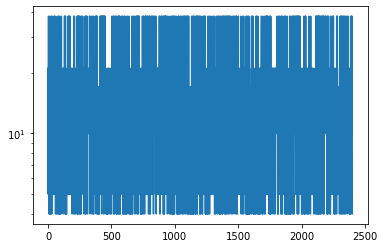

In [111]:
plt.semilogy(feat_tr[:,-1])

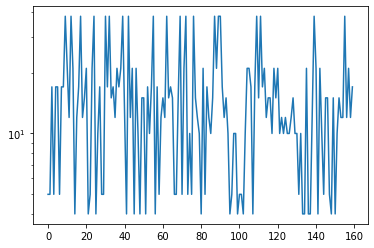

In [112]:
plt.semilogy(feat_test[:,-1])

### To obtain set of one hot codes for our labels

In [113]:
feat_test[:,-1] = [genre_set.index(w) for w in feat_test[:,-1]]
feat_tr[:,-1] = [genre_set.index(w) for w in feat_tr[:,-1]]

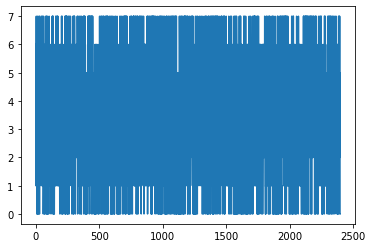

In [114]:
plt.plot(feat_tr[:,-1])

In [115]:
num_classes = len(genre_set)
one_hot = np.zeros((num_classes, num_classes*tr_len))
print(one_hot.shape)
for index_i, i in enumerate(feat_tr[:,-1]):
    one_hot[int(i),index_i] = 1


(8, 2400)


In [116]:
feat_tr[0:10,-1]

array([6, 1, 1, 4, 7, 3, 4, 3, 3, 0], dtype=object)

In [117]:
print(one_hot[:,0:10])
print(one_hot.shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
(8, 2400)


## Training Stage

### Setting up data 

In [118]:
x_train = tr_features/1000
x_test = test_features/1000
y_train = feat_tr[:,-1]
y_test = feat_test[:,-1]

In [119]:
class_set = list(range(num_classes))
class_lbl = [genre_set[i] for i in class_set]
class_name = [main_label_dict[genre_set[i]] for i in class_set]
label_dict = dict(zip(class_name,class_set))

In [120]:
label_dict

{'Jazz': 0,
 'Classical': 1,
 'Pop': 2,
 'Rock': 3,
 'Electronic': 4,
 'Folk': 5,
 'Hip-Hop': 6,
 'Experimental': 7}

In [121]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize=(8,8))
    plt.subplots()
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    
    ax = plt.gca();

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.gcf().subplots_adjust(bottom=0.15)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels1 = np.zeros((num_records, num_classes))
    #print(true_labels.shape)
    for index_i, i in enumerate(true_labels):
        #print(index_i,i)
        true_labels1[index_i,int(i)] = 1
    return true_labels1

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    #print(pred)
    one_hot_true = one_hot_encoder(y_test, len(pred), num_classes)
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

### Boosting

In [122]:
%%time
# Train

xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.01, objective='multi:hardprob', \
                                   n_estimators=700, sub_sample = 0.9, num_class = num_classes)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)


NameError: name 'xgb' is not defined

In [123]:
pred = np.argmax(pred_probs, axis=-1)
print('Test Error: ',len(y_test[y_test!=pred])/len(y_test))

Test Error:  0.88125


Test Set Accuracy =  0.12


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test Set F-score =  0.08
ROC AUC = 0.494
Confusion matrix, without normalization
[[ 0  6  0 11  0  1  0  2]
 [ 2  6  0 10  0  1  1  0]
 [ 4  8  0  5  0  2  0  1]
 [ 3  5  0  9  0  1  1  1]
 [ 4  5  1  7  0  1  0  2]
 [ 1  8  0  9  0  0  1  1]
 [ 2  8  0  6  0  1  1  2]
 [ 0  5  0 11  0  0  1  3]]


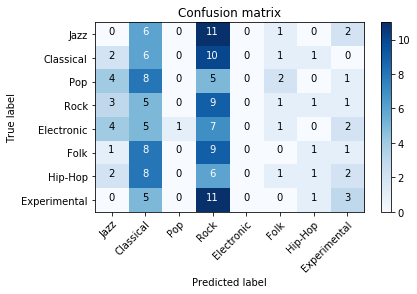

In [124]:
display_results(np.array(y_test,dtype=int), pred_probs)

### SVM 

##### Before changes were made:
Test Set Accuracy =  0.26
Test Set F-score =  0.25
ROC AUC = 0.642
Confusion matrix, without normalization
[[ 4  2  3  4  1  3  0  3]
 [ 0 20  0  0  0  0  0  0]
 [ 3  0  4 11  0  1  1  0]
 [ 6  1  2  5  0  1  5  0]
 [ 2  1  1  8  1  3  1  3]
 [ 5  1  0  2  1  0  8  3]
 [ 1  0  0  3  0  9  4  3]
 [ 1  0  1  4  1  1  8  4]]
 

##### After removing rock


Test Set Accuracy =  0.31
Test Set F-score =  0.30
ROC AUC = 0.658
Confusion matrix, without normalization
[[ 7  0  4  4  2  1  2]
 [ 0 20  0  0  0  0  0]
 [ 5  0  4  2  4  5  0]
 [ 1  1  9  2  1  2  4]
 [ 5  1  2  2  1  4  5]
 [ 1  0  0  1  9  5  4]
 [ 1  2  2  3  1  6  5]]
 
 
##### After removing jazz

Test Set Accuracy =  0.33
Test Set F-score =  0.28
ROC AUC = 0.713
Confusion matrix, without normalization
[[ 6  4  0  6  1  1  2]
 [ 1 14  0  2  2  1  0]
 [12  2  0  5  0  0  1]
 [ 1  1  1 15  0  0  2]
 [ 1  2  3  7  0  4  3]
 [ 0  0  1  8  2  5  4]
 [ 2  0  0  6  1  5  6]]

In [125]:
cl_weight = dict(pd.Series(np.array(y_train,dtype=int)).value_counts(normalize=True))

In [126]:
cl_weight

{7: 0.125,
 5: 0.125,
 3: 0.125,
 1: 0.125,
 6: 0.125,
 4: 0.125,
 2: 0.125,
 0: 0.125}

In [127]:
%%time

# Train
svm_classifier = SVC(C=10000.0, kernel = 'rbf', probability = True, class_weight=cl_weight)
svm_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

E:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 2.02 s


In [128]:
pred = np.argmax(pred_probs, axis=-1)
print('Test Error: ',len(y_test[y_test!=pred])/len(y_test))

Test Error:  0.73125


Test Set Accuracy =  0.27
Test Set F-score =  0.25
ROC AUC = 0.642
Confusion matrix, without normalization
[[ 5  2  3  4  1  2  0  3]
 [ 0 20  0  0  0  0  0  0]
 [ 4  0  3 11  0  1  1  0]
 [ 6  1  2  5  0  1  5  0]
 [ 2  1  1  8  1  3  1  3]
 [ 5  1  0  2  1  0  8  3]
 [ 1  0  0  3  0  9  4  3]
 [ 1  0  1  4  1  0  8  5]]


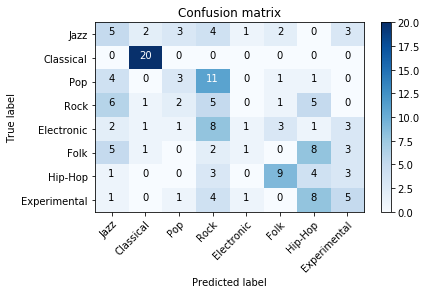

In [130]:
display_results(np.array(y_test,dtype=int), pred_probs)
plt.savefig('Classifier_single_label_parent_snn__SVM.eps', format='eps')

### Random Forest

In [131]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

Wall time: 4.4 s


Test Set Accuracy =  0.29
Test Set F-score =  0.29
ROC AUC = 0.691
Confusion matrix, without normalization
[[ 6  1  2  3  3  2  1  2]
 [ 0 20  0  0  0  0  0  0]
 [ 0  0  7  7  3  0  2  1]
 [ 5  0  2  2  6  2  3  0]
 [ 4  0  1  6  3  2  3  1]
 [ 4  0  0  3  2  2  3  6]
 [ 0  0  0  2  5  5  4  4]
 [ 2  2  1  3  4  1  4  3]]


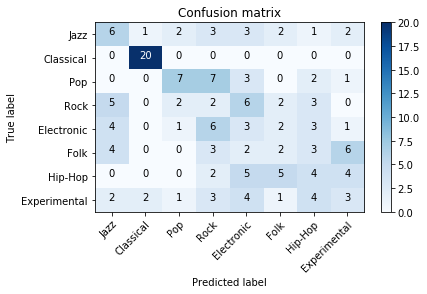

In [133]:
# Results
display_results(np.array(y_test,dtype=int), pred_probs)
plt.savefig('Classifier_single_label_parent_snn__Random_Forest.eps', format='eps')

### Logistic Regression

In [134]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

E:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 61.8 ms


Test Set Accuracy =  0.23


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test Set F-score =  0.17
ROC AUC = 0.558
Confusion matrix, without normalization
[[ 5  3  0  7  0  1  1  3]
 [ 0 20  0  0  0  0  0  0]
 [ 1  0  0 17  0  1  0  1]
 [ 3 10  0  6  0  1  0  0]
 [ 2  3  0 13  0  1  0  1]
 [ 0  8  1  7  0  2  2  0]
 [ 2  4  0 10  0  1  0  3]
 [ 3  3  0  8  0  0  2  4]]


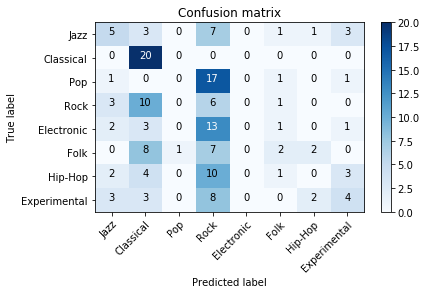

In [135]:
# Results
display_results(np.array(y_test,dtype=int), pred_probs)
plt.savefig('Classifier_single_label_parent_snn__logreg.eps', format='eps')

### Neural Network

In [136]:
from torch import nn

In [137]:
import torch

In [138]:
x_train = x_train.T
x_train.shape

(19, 2400)

In [57]:
x_test = x_test.T
x_test.shape

(19, 160)

In [58]:
y_train.shape

(2400,)

In [59]:
y_train = y_train.T
y_train.shape

(2400,)

In [60]:
def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size))
    d[lbl, np.arange(lbl.size)] = 1
    return d

In [61]:
def onehot2label(d):
    lbl = d.argmax(axis=0)
    return lbl

In [62]:
# turn labels into one hot
y_train.shape
print(type(y_train))
y_train = y_train.astype(int)
y_train_onehot = label2onehot(y_train)

<class 'numpy.ndarray'>


In [63]:
def init_shallow(Ni, Nh, No):
    b1 = np.random.randn(Nh, 1) / np.sqrt((Ni+1.)/2.)
    W1 = np.random.randn(Nh, Ni) / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1) / np.sqrt((Nh+1.))
    W2 = np.random.randn(No, Nh) / np.sqrt((Nh+1.))
    return W1, b1, W2, b2
Ni = x_train.shape[0]
Nh = 150
No = y_train_onehot.shape[0]
netinit = init_shallow(Ni, Nh, No)

In [64]:
print(y_train_onehot)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [65]:
def softmax(a):
    a_max = np.zeros((1,60000))
    a_max = a.max(axis = 0)
    a_sane = a - a_max
    a_sane_exp = np.exp(a_sane)
    y = a_sane_exp/(a_sane_exp.sum(axis = 0))
    return y

In [66]:
def softmaxp(a,e):
    k = softmax(a)
    part1 = np.multiply(k,e)
    new = part1.sum(axis = 0)
    part2 = np.multiply(new.T,k)
    return(part1 - part2)

In [67]:
def relu(a):
    return(np.where(a>0,a,0))

In [68]:
def relup(a,e):
    a = np.where(a>0,1,0)
    return(a*e)

In [69]:
def forwardprop_shallow(x, net):
#     print(net)
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
#     print("Shape of W1 is ", W1.shape)
#     print(x.shape)
    Z1 = W1.dot(x) + b1
    a1 = relu(Z1)
    a2 = W2.dot(a1) + b2
    y = softmax(a2)
    return y
yinit = forwardprop_shallow(x_train, netinit)

In [70]:
def eval_loss(y, d):
    sum_vert = -np.log(y)*d
    return(sum_vert.sum()/y.shape[1])
print(eval_loss(yinit, y_train_onehot), 'should be around .26')

2.1100737930979685 should be around .26


In [71]:
def eval_perfs(y, lbl):
    y_oneD = onehot2label(y)
    perf_par = (y_oneD != lbl)
    sum_perf_par = perf_par.sum()
    return (sum_perf_par/lbl.shape[0])*100
print(eval_perfs(yinit, y_train))

87.5


In [72]:
def update_shallow(x, d, net, gamma=.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]
    gamma = gamma / x.shape[1] # normalized by the training dataset size
    Z1 = W1.dot(x) + b1
    a1 = relu(Z1)
    a2 = W2.dot(a1) + b2
    y = softmax(a2)
    e2 = - d / y
    delta2 = softmaxp(a2,e2)
    e1 = W2.T.dot(delta2)
    delta1 = relup(a1, e1) 
    W2 = W2 - gamma * delta2.dot(a1.T)
    W1 = W1 - gamma * delta1.dot(x.T)
    b2 = b2 - gamma * delta2.sum(axis =1, keepdims = True )
    b1 = b1 - gamma * delta1.sum(axis =1, keepdims = True )
    return W1, b1, W2, b2

In [73]:
def backprop_shallow(x, d, net, T, gamma=.05):
    lbl = onehot2label(d)
    for t in range(T):
        net = update_shallow(x, d, net)
        #net = [W1,b1,W2,b2]
        y = forwardprop_shallow(x, net)
        loss = eval_loss(y, d)
        print(loss)
        performance = eval_perfs(y, lbl)
        print(performance)
    return net

In [74]:
nettrain_batch2 = backprop_shallow(x_train, y_train_onehot, netinit, 10000)

2.1069185845952645
87.5
2.1041113415580166
87.5
2.1016095424792227
87.5
2.0993765723930116
87.5
2.0973804331371304
87.5
2.0955935467531246
87.5
2.093991990721879
87.54166666666666
2.092554648818321
87.5
2.091263100697707
87.54166666666666
2.090100573569686
87.54166666666666
2.089052813686141
87.54166666666666
2.0881079481111655
87.54166666666666
2.0872540354816964
87.54166666666666
2.086480951713228
87.625
2.085780217306798
87.79166666666667
2.0851442123868096
87.79166666666667
2.0845662277217203
87.625
2.084039444487486
87.625
2.0835581726491466
87.70833333333333
2.0831174273992947
87.66666666666667
2.0827129533841653
87.70833333333333
2.082341047833765
87.58333333333333
2.0819984445424407
87.45833333333334
2.0816822644521444
87.58333333333333
2.0813894882676682
87.5
2.0811176212085525
87.54166666666666
2.0808648793823346
87.45833333333334
2.080629270729482
87.33333333333333
2.080409123366361
87.08333333333333
2.080202395839035
86.75
2.0800076216651107
86.45833333333334
2.079823248755

80.20833333333334
2.0598123926513057
80.125
2.059739232536764
80.16666666666666
2.0596661642674006
80.20833333333334
2.0595931952115105
80.25
2.059520269005593
80.20833333333334
2.0594474138853514
80.29166666666666
2.0593746234510375
80.29166666666666
2.059301911605286
80.29166666666666
2.059229294590161
80.25
2.059156782811652
80.29166666666666
2.0590843510528587
80.33333333333333
2.0590120161727725
80.375
2.058939788604658
80.375
2.0588676249126747
80.33333333333333
2.0587955112300307
80.33333333333333
2.058723486745177
80.33333333333333
2.0586515741207085
80.25
2.0585797090451954
80.33333333333333
2.058507901856619
80.45833333333333
2.058436180748134
80.5
2.0583645417845786
80.5
2.0582929235825276
80.58333333333333
2.058221352012515
80.54166666666667
2.0581498372683367
80.5
2.0580783900120587
80.5
2.05800706104359
80.5
2.057935786163887
80.41666666666667
2.057864557100539
80.375
2.0577934031554608
80.375
2.0577222997887517
80.33333333333333
2.0576512288969973
80.375
2.05758020850019

79.83333333333333
2.043653240207365
79.83333333333333
2.0435952517795206
79.79166666666667
2.0435373196080167
79.79166666666667
2.0434794468871784
79.83333333333333
2.0434216098898657
79.875
2.043363830484146
79.875
2.0433060957698213
79.875
2.043248398519264
79.875
2.0431907523841732
79.875
2.043133161729297
79.875
2.0430756065997038
79.875
2.043018102702294
79.875
2.0429606628963497
79.875
2.042903280122327
79.875
2.04284595868909
79.875
2.0427886980402343
79.875
2.042731481461509
79.875
2.0426743047294784
79.875
2.042617185319915
79.875
2.0425601064456353
79.91666666666667
2.0425030783994886
79.91666666666667
2.0424461171270383
79.91666666666667
2.0423892096045275
79.91666666666667
2.0423323564784925
79.91666666666667
2.042275551530011
79.91666666666667
2.042218800317233
79.875
2.0421621128365963
79.83333333333333
2.0421054744426432
79.83333333333333
2.0420488871504845
79.83333333333333
2.041992350056645
79.83333333333333
2.0419358513901678
79.83333333333333
2.041879397409214
79.833

2.030716177576771
79.95833333333333
2.0306697927537893
79.95833333333333
2.030623446061222
79.95833333333333
2.0305771574571416
79.95833333333333
2.0305309342692848
79.95833333333333
2.0304847386407845
79.95833333333333
2.0304385684106143
79.95833333333333
2.0303924452205977
79.95833333333333
2.0303463793429266
79.95833333333333
2.030300365969595
79.95833333333333
2.030254396912879
79.95833333333333
2.0302084667250715
79.91666666666667
2.030162587017422
79.91666666666667
2.0301167567854823
79.91666666666667
2.030070970395766
79.91666666666667
2.030025228438729
79.91666666666667
2.0299795228678517
79.875
2.0299338521555637
79.875
2.029888217130786
79.875
2.029842617218725
79.875
2.0297970642623597
79.875
2.0297515553408694
79.91666666666667
2.029706095222143
79.875
2.0296606756261597
79.83333333333333
2.02961529553303
79.79166666666667
2.0295699690650326
79.75
2.029524683670449
79.75
2.029479437858027
79.70833333333334
2.029434235610963
79.70833333333334
2.0293890718890903
79.7083333333

2.0208382481125056
79.04166666666667
2.0208018497525004
79.04166666666667
2.0207654910073556
78.95833333333333
2.020729177739067
78.95833333333333
2.0206929259479156
78.95833333333333
2.0206567201268224
78.91666666666667
2.0206205560391886
78.91666666666667
2.0205844321994935
78.91666666666667
2.0205483477295023
78.91666666666667
2.0205122979674184
78.91666666666667
2.020476294312644
78.91666666666667
2.020440331282941
78.91666666666667
2.0204044051537022
78.91666666666667
2.020368523064558
78.875
2.0203326785091824
78.875
2.020296861251308
78.875
2.0202610808480763
78.875
2.0202253344050005
78.875
2.0201896595593123
78.875
2.020154044160576
78.875
2.020118463816043
78.875
2.0200829204834707
78.875
2.02004741823986
78.875
2.020011973019177
78.875
2.0199765558267915
78.875
2.0199411607603794
78.91666666666667
2.019905796786328
78.91666666666667
2.019870465290445
78.91666666666667
2.0198351612287575
78.91666666666667
2.0197998910011137
78.91666666666667
2.0197646662526854
78.916666666666

78.54166666666667
2.0131023161945394
78.54166666666667
2.0130750599261003
78.54166666666667
2.013047836727205
78.54166666666667
2.0130206451668107
78.54166666666667
2.012993486555606
78.54166666666667
2.0129663599866063
78.54166666666667
2.0129392680994442
78.54166666666667
2.0129122101492745
78.54166666666667
2.0128851812121225
78.54166666666667
2.0128581818484466
78.54166666666667
2.012831218132504
78.58333333333334
2.012804287916392
78.58333333333334
2.012777388978252
78.58333333333334
2.012750517210204
78.54166666666667
2.0127236798058132
78.58333333333334
2.0126968814116117
78.58333333333334
2.0126701174235184
78.54166666666667
2.0126433852134316
78.54166666666667
2.0126166861800443
78.54166666666667
2.012590018557404
78.54166666666667
2.012563382716869
78.54166666666667
2.0125367783047854
78.54166666666667
2.012510209576974
78.54166666666667
2.0124836762693574
78.54166666666667
2.0124571779654086
78.54166666666667
2.012430713445357
78.54166666666667
2.012404280332065
78.5
2.01237

77.875
2.0068860861770825
77.875
2.006866576094238
77.875
2.006847090091986
77.875
2.006827617108833
77.875
2.0068081690608097
77.83333333333333
2.0067887456868685
77.83333333333333
2.006769346928842
77.83333333333333
2.0067499730603253
77.83333333333333
2.0067306195668846
77.83333333333333
2.0067112815124117
77.83333333333333
2.006691956107805
77.83333333333333
2.0066726567558164
77.83333333333333
2.0066533789685557
77.83333333333333
2.006634121504419
77.83333333333333
2.0066148843362916
77.79166666666667
2.0065956733837513
77.79166666666667
2.006576495548493
77.79166666666667
2.0065573433148356
77.79166666666667
2.006538216934944
77.79166666666667
2.006519108260688
77.83333333333333
2.0065000406063858
77.79166666666667
2.006481015550088
77.79166666666667
2.0064620147006127
77.79166666666667
2.0064430378248814
77.79166666666667
2.0064240851545843
77.79166666666667
2.006405162532877
77.75
2.006386259270021
77.75
2.0063673418647414
77.75
2.006348448351246
77.75
2.006329577267243
77.75
2

2.0027985670661597
77.70833333333333
2.0027844832905743
77.70833333333333
2.0027704154836456
77.70833333333333
2.0027563660513494
77.70833333333333
2.00274233366522
77.70833333333333
2.0027283165044634
77.66666666666666
2.0027143124985334
77.66666666666666
2.0027003190654202
77.66666666666666
2.0026863429715087
77.66666666666666
2.0026723852218256
77.66666666666666
2.0026584456450744
77.66666666666666
2.002644522479994
77.66666666666666
2.002630615867338
77.66666666666666
2.002616725683825
77.66666666666666
2.0026028527449116
77.66666666666666
2.002588996599354
77.66666666666666
2.0025751567932444
77.66666666666666
2.00256132481799
77.66666666666666
2.0025475104376906
77.66666666666666
2.0025337132783685
77.66666666666666
2.0025199320261775
77.66666666666666
2.0025061690714905
77.66666666666666
2.002492422115818
77.66666666666666
2.002478688546394
77.66666666666666
2.002464971569681
77.66666666666666
2.002451266917144
77.66666666666666
2.00243757379183
77.66666666666666
2.0024239001249

1.9998549318282597
77.79166666666667
1.9998443176217722
77.79166666666667
1.9998337171607965
77.79166666666667
1.999823129214773
77.79166666666667
1.9998125516364802
77.79166666666667
1.9998019864143441
77.79166666666667
1.9997914351559765
77.79166666666667
1.9997808970395992
77.79166666666667
1.9997703702282859
77.79166666666667
1.9997598577794065
77.79166666666667
1.9997493570001053
77.79166666666667
1.9997388691268998
77.79166666666667
1.9997283953746239
77.79166666666667
1.9997179410577628
77.79166666666667
1.9997074941185387
77.79166666666667
1.9996970595848202
77.79166666666667
1.9996866400135218
77.79166666666667
1.9996762324303934
77.75
1.9996658392448516
77.75
1.9996554575532415
77.75
1.999645088101471
77.75
1.9996347313580316
77.75
1.9996243856449185
77.75
1.9996140492693413
77.75
1.9996037216390479
77.75
1.999593404541159
77.75
1.999583097997777
77.75
1.9995728019210226
77.75
1.9995625167225246
77.75
1.9995522436131061
77.75
1.9995419821332552
77.75
1.999531731452219
77.75
1

1.9974788843842741
77.79166666666667
1.9974706667103683
77.79166666666667
1.9974624557733467
77.79166666666667
1.9974542544632432
77.79166666666667
1.9974460663290456
77.79166666666667
1.9974378852670316
77.79166666666667
1.9974297110199746
77.79166666666667
1.9974215464714087
77.79166666666667
1.997413393476551
77.79166666666667
1.9974052487596168
77.79166666666667
1.997397111523156
77.79166666666667
1.9973889803192788
77.79166666666667
1.997380850435092
77.83333333333333
1.9973727275927695
77.83333333333333
1.9973646101133542
77.83333333333333
1.9973564966066162
77.83333333333333
1.9973483905550427
77.83333333333333
1.9973402926021633
77.83333333333333
1.997332203629295
77.83333333333333
1.9973241213617132
77.83333333333333
1.9973160422155671
77.83333333333333
1.9973079659167188
77.83333333333333
1.9972998967611753
77.83333333333333
1.9972918389643959
77.83333333333333
1.9972837933151337
77.875
1.9972757566498949
77.91666666666667
1.9972677287175278
77.91666666666667
1.99725970802894

77.95833333333333
1.9956317652333875
77.95833333333333
1.995624970581849
77.95833333333333
1.9956181801045674
77.95833333333333
1.9956113958074517
77.95833333333333
1.995604617188357
77.95833333333333
1.9955978327339596
77.95833333333333
1.9955910520608953
77.95833333333333
1.9955842735893445
77.95833333333333
1.995577499846257
77.95833333333333
1.995570727775391
77.95833333333333
1.995563949382744
77.95833333333333
1.9955571747467238
77.95833333333333
1.995550403530011
78.0
1.995543635959308
78.0
1.9955368747425064
78.0
1.9955301212786063
78.0
1.9955233726034036
78.0
1.9955166318922928
78.0
1.9955098968683618
78.0
1.9955031660897533
77.95833333333333
1.9954964380358873
77.95833333333333
1.9954897165785004
77.95833333333333
1.9954829913659773
77.95833333333333
1.9954762704777174
77.95833333333333
1.9954695532782907
77.95833333333333
1.9954628397384762
77.95833333333333
1.9954561300034561
77.95833333333333
1.9954494251522863
77.95833333333333
1.9954427249446023
77.95833333333333
1.99543

77.66666666666666
1.9940839287848613
77.66666666666666
1.994078040570414
77.66666666666666
1.9940721482026662
77.66666666666666
1.9940662607839825
77.66666666666666
1.9940603763560356
77.66666666666666
1.9940544951787864
77.66666666666666
1.9940486150033958
77.66666666666666
1.9940427383973114
77.70833333333333
1.9940368658866854
77.70833333333333
1.9940309967062888
77.70833333333333
1.9940251302906427
77.70833333333333
1.9940192668671524
77.70833333333333
1.994013406531202
77.70833333333333
1.994007550287691
77.70833333333333
1.9940016962164637
77.70833333333333
1.9939958448653214
77.70833333333333
1.9939899961835041
77.70833333333333
1.993984150171379
77.70833333333333
1.9939783071270674
77.70833333333333
1.993972473117323
77.70833333333333
1.9939666414725241
77.70833333333333
1.9939608120418477
77.70833333333333
1.9939549850030025
77.66666666666666
1.9939491606703343
77.66666666666666
1.9939433413173018
77.66666666666666
1.9939375280394798
77.66666666666666
1.9939317188013534
77.666

1.9926901838620195
77.625
1.9926848359909468
77.625
1.9926794900720393
77.625
1.9926741459320723
77.625
1.992668803367784
77.625
1.9926634626552107
77.625
1.992658124292614
77.625
1.992652787137082
77.625
1.9926474442496147
77.625
1.9926420999440735
77.625
1.992636754320398
77.625
1.9926314098765192
77.625
1.9926260688383532
77.625
1.9926207329424968
77.625
1.9926153995609408
77.625
1.992610067798247
77.625
1.9926047378520721
77.625
1.9925994093739563
77.625
1.9925940823453356
77.625
1.9925887582726378
77.625
1.9925834356994578
77.625
1.9925781147723252
77.625
1.9925727953734675
77.625
1.9925674792424781
77.625
1.9925621649230212
77.625
1.992556852306452
77.625
1.992551541091411
77.625
1.9925462315551492
77.625
1.992540923583152
77.625
1.9925356172654691
77.625
1.9925303122780833
77.625
1.9925250086716157
77.625
1.9925197057729382
77.625
1.992514400789704
77.625
1.9925090893170492
77.625
1.9925037793370628
77.58333333333334
1.9924984705746782
77.58333333333334
1.9924931622951754
77.583

1.9913075347435851
77.79166666666667
1.991302519810323
77.79166666666667
1.9912975055390385
77.79166666666667
1.9912924915427357
77.79166666666667
1.9912874786613235
77.79166666666667
1.9912824664890252
77.79166666666667
1.9912774553694848
77.79166666666667
1.991272445076238
77.79166666666667
1.9912674311097753
77.79166666666667
1.9912624178912388
77.79166666666667
1.9912574061525083
77.79166666666667
1.991252401816574
77.79166666666667
1.9912474026259277
77.79166666666667
1.9912424031944063
77.79166666666667
1.9912374042634162
77.79166666666667
1.991232405876543
77.79166666666667
1.9912274085787267
77.79166666666667
1.991222411797454
77.79166666666667
1.9912174171124564
77.79166666666667
1.9912124245380127
77.79166666666667
1.9912074328205445
77.79166666666667
1.9912024417703942
77.79166666666667
1.9911974510047494
77.79166666666667
1.9911924607861768
77.79166666666667
1.9911874701803853
77.79166666666667
1.9911824805592369
77.79166666666667
1.9911774909236188
77.79166666666667
1.9911

1.9900650968550293
77.75
1.9900602255542927
77.75
1.9900553550002065
77.75
1.9900504846806248
77.75
1.9900456132374684
77.75
1.990040743539885
77.75
1.9900358805750709
77.79166666666667
1.9900310187116206
77.79166666666667
1.9900261571264597
77.79166666666667
1.9900212961198
77.79166666666667
1.9900164357850285
77.79166666666667
1.9900115757175063
77.79166666666667
1.9900067164570028
77.79166666666667
1.9900018574044562
77.79166666666667
1.9899969989780637
77.79166666666667
1.9899921411483543
77.79166666666667
1.9899872818205437
77.79166666666667
1.9899824199769607
77.79166666666667
1.989977558255188
77.79166666666667
1.989972697243361
77.75
1.9899678365034952
77.75
1.9899629744799097
77.75
1.9899581137542957
77.75
1.9899532594759852
77.75
1.9899484153957534
77.75
1.9899435713444587
77.75
1.989938727749357
77.75
1.9899338838556526
77.75
1.989929036389107
77.75
1.9899241842389863
77.75
1.989919331413258
77.75
1.9899144791121224
77.75
1.9899096280739543
77.75
1.9899047782659431
77.75
1.9

1.988851717311008
77.33333333333333
1.9888470084671948
77.33333333333333
1.9888423005237439
77.33333333333333
1.9888375911941534
77.33333333333333
1.9888328820345347
77.33333333333333
1.988828172734567
77.33333333333333
1.9888234634360495
77.33333333333333
1.988818755338968
77.33333333333333
1.9888140502658478
77.33333333333333
1.988809344367955
77.33333333333333
1.9888046382026328
77.33333333333333
1.9887999385574036
77.33333333333333
1.9887952394554194
77.33333333333333
1.9887905387019116
77.33333333333333
1.9887858355087027
77.33333333333333
1.9887811302106404
77.33333333333333
1.9887764250698963
77.29166666666667
1.9887717204055495
77.29166666666667
1.9887670156100996
77.29166666666667
1.9887623110913262
77.25
1.9887576094020025
77.25
1.9887529107514506
77.25
1.9887482087678094
77.25
1.988743507037118
77.25
1.988738806175772
77.25
1.9887341038585866
77.25
1.9887294034249607
77.25
1.9887247051069585
77.25
1.9887200055906071
77.25
1.988715306459858
77.25
1.9887106072598801
77.25
1.98

77.29166666666667
1.9877105532056343
77.29166666666667
1.987705899939164
77.29166666666667
1.987701244854164
77.29166666666667
1.9876965898645593
77.29166666666667
1.9876919355498932
77.29166666666667
1.9876872813532
77.29166666666667
1.9876826270396661
77.29166666666667
1.9876779692463393
77.29166666666667
1.9876733097453965
77.29166666666667
1.987668650053053
77.29166666666667
1.987663991106617
77.29166666666667
1.9876593327095475
77.29166666666667
1.9876546750494473
77.29166666666667
1.9876500173376503
77.29166666666667
1.9876453592038639
77.29166666666667
1.9876407004744976
77.29166666666667
1.9876360411132918
77.29166666666667
1.987631381712486
77.29166666666667
1.987626721438494
77.29166666666667
1.9876220613327893
77.29166666666667
1.9876174013526917
77.29166666666667
1.9876127411955409
77.29166666666667
1.9876080817808286
77.29166666666667
1.9876034214855391
77.29166666666667
1.9875987598353144
77.29166666666667
1.9875940976147974
77.29166666666667
1.9875894354605812
77.2916666

77.04166666666666
1.9865250710534443
77.04166666666666
1.986520468433758
77.04166666666666
1.9865158652497723
77.04166666666666
1.9865112621082694
77.04166666666666
1.9865066592349983
77.0
1.9865020559326596
77.0
1.9864974534552244
77.0
1.9864928500802133
77.0
1.9864882464112688
77.0
1.9864836392342902
77.0
1.9864790320939119
77.0
1.9864744245699422
77.0
1.9864698166030674
77.0
1.986465205780072
77.0
1.9864605955028423
77.0
1.9864559850058852
77.0
1.9864513727139415
77.0
1.9864467609637189
77.0
1.9864421499437745
77.0
1.9864375392539466
77.0
1.9864329289516987
77.0
1.9864283186773302
77.04166666666666
1.9864237084821044
77.04166666666666
1.9864190983420016
77.04166666666666
1.9864144880037595
77.04166666666666
1.9864098780004757
77.04166666666666
1.9864052688683547
77.04166666666666
1.986400660169985
77.04166666666666
1.9863960527452162
77.04166666666666
1.986391444994479
77.04166666666666
1.9863868374305318
77.04166666666666
1.9863822301630716
77.04166666666666
1.986377620804945
77.08

77.08333333333334
1.985440767715521
77.08333333333334
1.9854361829205565
77.08333333333334
1.9854315983453577
77.08333333333334
1.9854270140594352
77.08333333333334
1.9854224290720857
77.08333333333334
1.9854178444981312
77.08333333333334
1.9854132603480263
77.08333333333334
1.9854086766092875
77.08333333333334
1.985404093348654
77.08333333333334
1.985399509705901
77.08333333333334
1.9853949244636055
77.08333333333334
1.9853903390398167
77.08333333333334
1.985385753646358
77.08333333333334
1.9853811680321103
77.08333333333334
1.985376582752214
77.125
1.9853719983973
77.125
1.9853674149108569
77.08333333333334
1.9853628308662463
77.08333333333334
1.9853582470355173
77.08333333333334
1.9853536636605889
77.08333333333334
1.9853490800221911
77.08333333333334
1.9853444949894705
77.08333333333334
1.9853399100739344
77.08333333333334
1.9853353250667267
77.08333333333334
1.9853307398799007
77.08333333333334
1.9853261539905267
77.08333333333334
1.9853215666473452
77.08333333333334
1.98531697956

1.98432290429125
77.04166666666666
1.9843183184568893
77.04166666666666
1.9843137329882214
77.04166666666666
1.98430914736857
77.04166666666666
1.984304561738879
77.04166666666666
1.984299974526711
77.04166666666666
1.9842953835676838
77.04166666666666
1.984290793951526
77.04166666666666
1.984286211806037
77.04166666666666
1.98428162972162
77.04166666666666
1.9842770477045026
77.04166666666666
1.9842724657732962
77.04166666666666
1.9842678834149732
77.04166666666666
1.9842633008205488
77.0
1.9842587178203215
77.0
1.9842541341751438
77.0
1.9842495509520182
77.0
1.9842449682981085
77.0
1.9842403850792198
77.0
1.9842358016055748
77.0
1.9842312178507708
77.0
1.9842266330986336
77.0
1.9842220503920267
77.0
1.9842174677390723
77.0
1.9842128850326677
77.0
1.984208302514968
77.0
1.9842037195806308
77.0
1.984199136728743
77.0
1.984194553740097
77.0
1.98418997067142
77.0
1.9841853873019488
77.0
1.9841808034639015
77.0
1.9841762195676749
77.0
1.984171635950867
77.0
1.9841670521231167
77.0
1.98416

1.9831164234705734
76.875
1.98311185067592
76.875
1.9831072778644288
76.875
1.9831027052444554
76.875
1.983098132904432
76.875
1.9830935606299567
76.875
1.9830889883393785
76.875
1.983084415930432
76.875
1.983079843496843
76.875
1.9830752711413595
76.875
1.9830706988672364
76.875
1.983066126794746
76.875
1.9830615546018588
76.875
1.9830569824078472
76.875
1.9830524102241278
76.875
1.9830478378704288
76.875
1.983043265479958
76.83333333333333
1.9830386919178375
76.83333333333333
1.9830341126027966
76.83333333333333
1.9830295337131751
76.83333333333333
1.9830249545120322
76.83333333333333
1.9830203752059898
76.83333333333333
1.9830157961901356
76.83333333333333
1.983011214978246
76.79166666666667
1.983006633453626
76.79166666666667
1.9830020519781355
76.79166666666667
1.9829974703450277
76.79166666666667
1.982992888933604
76.75
1.9829883077808563
76.75
1.9829837263242556
76.70833333333333
1.9829791451308578
76.70833333333333
1.982974563951538
76.70833333333333
1.9829699826775526
76.70833

76.58333333333334
1.9819104933311753
76.58333333333334
1.9819059072223235
76.58333333333334
1.9819013209941947
76.58333333333334
1.981896735023186
76.58333333333334
1.9818921488203736
76.58333333333334
1.9818875625004966
76.58333333333334
1.9818829763975774
76.58333333333334
1.981878390571247
76.58333333333334
1.9818738046930324
76.58333333333334
1.9818692188589202
76.58333333333334
1.9818646332657783
76.58333333333334
1.9818600474305863
76.58333333333334
1.9818554615015227
76.58333333333334
1.9818508756228868
76.58333333333334
1.9818462899143132
76.58333333333334
1.981841704249495
76.58333333333334
1.9818371188650865
76.58333333333334
1.9818325290843468
76.58333333333334
1.9818279391724059
76.58333333333334
1.9818233490137471
76.58333333333334
1.9818187589202285
76.58333333333334
1.9818141688493895
76.58333333333334
1.9818095785069654
76.58333333333334
1.9818049881499917
76.58333333333334
1.9818003980876704
76.58333333333334
1.981795810812342
76.58333333333334
1.981791228709332
76.583

76.45833333333333
1.980858391923125
76.45833333333333
1.9808537659434804
76.45833333333333
1.9808491414932337
76.45833333333333
1.9808445145972378
76.45833333333333
1.9808398747963794
76.45833333333333
1.9808352366649182
76.41666666666667
1.980830601586647
76.41666666666667
1.98082596641156
76.41666666666667
1.9808213312465053
76.41666666666667
1.9808166962823808
76.41666666666667
1.9808120609023796
76.41666666666667
1.9808074257367068
76.41666666666667
1.9808027886722543
76.41666666666667
1.9807981499778406
76.41666666666667
1.9807935110119028
76.41666666666667
1.9807888728099639
76.41666666666667
1.980784235516289
76.41666666666667
1.9807795982589895
76.41666666666667
1.9807749607194676
76.41666666666667
1.9807703233728793
76.41666666666667
1.980765685867833
76.41666666666667
1.9807610496788053
76.41666666666667
1.9807564141494867
76.41666666666667
1.9807517707340105
76.41666666666667
1.9807471214376158
76.41666666666667
1.980742471614788
76.41666666666667
1.9807378223015433
76.41666

1.9796040795010965
76.41666666666667
1.9795993851536087
76.41666666666667
1.9795946908136342
76.41666666666667
1.979589997010647
76.41666666666667
1.9795853046407543
76.41666666666667
1.9795806124656254
76.41666666666667
1.9795759202720873
76.41666666666667
1.9795712279473445
76.41666666666667
1.9795665348226537
76.41666666666667
1.9795618408761617
76.41666666666667
1.9795571452302578
76.41666666666667
1.9795524457646039
76.41666666666667
1.9795477499137413
76.41666666666667
1.97954307893824
76.41666666666667
1.979538408288024
76.41666666666667
1.979533737880324
76.41666666666667
1.9795290681648257
76.41666666666667
1.9795243985862552
76.41666666666667
1.9795197288512236
76.41666666666667
1.979515061528513
76.41666666666667
1.9795103954804283
76.41666666666667
1.9795057286954219
76.41666666666667
1.979501057065068
76.41666666666667
1.9794963805736
76.41666666666667
1.9794917004759585
76.41666666666667
1.9794870287801087
76.41666666666667
1.9794823648345237
76.41666666666667
1.979477700

1.9784617049483741
76.54166666666666
1.9784568485532308
76.54166666666666
1.9784519857072844
76.54166666666666
1.978447114270828
76.54166666666666
1.9784422319074348
76.54166666666666
1.9784373511368247
76.54166666666666
1.9784324702925051
76.54166666666666
1.9784275815755246
76.54166666666666
1.9784226324036156
76.54166666666666
1.9784176596188912
76.54166666666666
1.9784126871308645
76.54166666666666
1.9784077119678287
76.5
1.9784027035666376
76.5
1.978397692063818
76.5
1.9783926484224208
76.5
1.9783875831901663
76.5
1.9783825263997035
76.5
1.9783775108403976
76.5
1.9783725083434323
76.5
1.9783675062782393
76.5
1.9783625053738274
76.5
1.9783575170607064
76.5
1.9783525286650387
76.5
1.9783475289116583
76.54166666666666
1.978342501096195
76.54166666666666
1.9783374639362985
76.54166666666666
1.9783324263877327
76.54166666666666
1.9783273788240758
76.54166666666666
1.9783223366490692
76.54166666666666
1.9783172833773692
76.54166666666666
1.978312220239702
76.54166666666666
1.97830712236

1.9773543631645127
76.54166666666666
1.9773497082227853
76.54166666666666
1.9773450524490113
76.54166666666666
1.9773403955077804
76.54166666666666
1.9773357237223759
76.54166666666666
1.9773310497381422
76.54166666666666
1.9773263756055368
76.54166666666666
1.9773216885531615
76.54166666666666
1.9773170157847748
76.54166666666666
1.9773123433982482
76.5
1.9773076774921814
76.5
1.9773030118466624
76.5
1.9772983459630806
76.5
1.9772936801061698
76.5
1.977289016670987
76.5
1.977284356633678
76.5
1.9772796889768658
76.5
1.9772750090872628
76.5
1.977270330494273
76.5
1.9772656569323661
76.5
1.9772609825542928
76.5
1.9772563061645625
76.5
1.977251630203994
76.5
1.9772469506418193
76.5
1.97724227178339
76.5
1.9772375932687494
76.5
1.9772329148500263
76.5
1.9772282368557517
76.5
1.9772235625309422
76.5
1.9772189077736186
76.5
1.9772142506764316
76.5
1.977209590529652
76.5
1.9772049272911787
76.5
1.977200259972659
76.5
1.9771955984001568
76.5
1.9771909417126585
76.5
1.9771862862110443
76.5
1.9

1.9762438545913237
76.29166666666667
1.976239233746498
76.29166666666667
1.9762346145148881
76.29166666666667
1.9762299987710599
76.29166666666667
1.976225384868085
76.29166666666667
1.976220770157566
76.29166666666667
1.976216155432865
76.29166666666667
1.9762115402069245
76.29166666666667
1.97620692553221
76.29166666666667
1.976202310521973
76.29166666666667
1.976197693380719
76.29166666666667
1.9761930763340418
76.29166666666667
1.976188459276816
76.29166666666667
1.976183842423729
76.29166666666667
1.9761792250013381
76.29166666666667
1.9761746082550986
76.29166666666667
1.9761699914383803
76.29166666666667
1.9761653747531818
76.29166666666667
1.976160757059305
76.29166666666667
1.976156134414764
76.25
1.976151510077225
76.25
1.9761468854201196
76.25
1.976142260758944
76.25
1.976137636378418
76.25
1.9761330120695841
76.25
1.9761283870442958
76.25
1.9761237636072693
76.25
1.9761191458382124
76.25
1.9761145272484009
76.25
1.9761099089455183
76.25
1.9761052903195215
76.25
1.9761006702

76.33333333333333
1.9751596368697437
76.33333333333333
1.9751549729877282
76.33333333333333
1.975150308676151
76.375
1.9751456435984311
76.375
1.9751409898866794
76.375
1.9751363361734715
76.375
1.9751316800494223
76.375
1.9751270283891638
76.375
1.975122376180577
76.375
1.9751177267246256
76.41666666666667
1.9751130758740079
76.41666666666667
1.9751084271527422
76.41666666666667
1.9751037841987575
76.41666666666667
1.975099141285432
76.375
1.9750944989154888
76.375
1.9750898558320784
76.375
1.9750852129206828
76.33333333333333
1.9750805703444019
76.33333333333333
1.9750759279818786
76.33333333333333
1.9750712857630894
76.33333333333333
1.9750666433844328
76.33333333333333
1.9750620012611193
76.33333333333333
1.9750573585086886
76.33333333333333
1.9750527160310458
76.33333333333333
1.9750480734666818
76.33333333333333
1.9750434306274838
76.33333333333333
1.9750387880805806
76.33333333333333
1.9750341452683202
76.33333333333333
1.975029502746465
76.33333333333333
1.9750248605997516
76.3

1.9739699266108433
76.25
1.9739652907990246
76.25
1.9739606554501827
76.25
1.9739560200402941
76.25
1.9739513847219041
76.25
1.973946749468843
76.25
1.9739421145959033
76.25
1.9739374791326216
76.25
1.9739328423868585
76.25
1.9739282056614809
76.25
1.9739235688641292
76.20833333333333
1.973918932355526
76.20833333333333
1.9739142948492328
76.20833333333333
1.9739096573407622
76.20833333333333
1.9739050199779271
76.20833333333333
1.9739003827059924
76.20833333333333
1.9738957447983132
76.20833333333333
1.9738911083001556
76.20833333333333
1.9738864715139448
76.20833333333333
1.9738818367693518
76.20833333333333
1.973877201365592
76.20833333333333
1.9738725663180572
76.20833333333333
1.9738679316923866
76.20833333333333
1.973863296705811
76.20833333333333
1.9738586617955287
76.20833333333333
1.9738540271584464
76.20833333333333
1.973849392218843
76.20833333333333
1.9738447576553175
76.20833333333333
1.9738401233646752
76.20833333333333
1.9738354900888744
76.20833333333333
1.9738308549270

1.9728443684128323
76.125
1.9728397403747078
76.125
1.972835112706712
76.125
1.972830484889741
76.125
1.972825856907484
76.125
1.972821229235168
76.125
1.9728166015301338
76.125
1.9728119736874994
76.125
1.972807345713494
76.125
1.9728027182390928
76.125
1.972798090491696
76.125
1.9727934629427473
76.125
1.9727888351637486
76.125
1.9727842080208813
76.125
1.9727795805696884
76.125
1.9727749530256142
76.125
1.9727703256656954
76.125
1.9727656980877266
76.125
1.9727610716993262
76.125
1.9727564434834222
76.125
1.9727518166042823
76.125
1.9727471889329906
76.125
1.9727425609354692
76.125
1.9727379343507736
76.125
1.9727333061365058
76.125
1.9727286793185654
76.125
1.9727240513371298
76.125
1.9727194243662158
76.125
1.9727147973005705
76.125
1.9727101695818632
76.16666666666667
1.9727055428105962
76.20833333333333
1.9727009150751151
76.20833333333333
1.9726962887550592
76.20833333333333
1.972691661432763
76.20833333333333
1.972687034393372
76.20833333333333
1.972682407341155
76.20833333333

76.16666666666667
1.9717709966940145
76.16666666666667
1.9717663737908713
76.16666666666667
1.971761750136071
76.16666666666667
1.9717571270077459
76.16666666666667
1.9717525039890351
76.16666666666667
1.971747880242711
76.16666666666667
1.971743257298767
76.16666666666667
1.9717386341942695
76.16666666666667
1.9717340105524768
76.16666666666667
1.9717293877947115
76.16666666666667
1.9717247644092912
76.16666666666667
1.971720140929562
76.16666666666667
1.9717155178563128
76.125
1.9717108944360298
76.125
1.9717062708264363
76.125
1.9717016480376772
76.125
1.9716970245451981
76.125
1.97169240097063
76.125
1.971687778774887
76.125
1.9716831551320921
76.125
1.971678531841724
76.125
1.971673909309194
76.125
1.9716692854915545
76.125
1.9716646627848438
76.125
1.9716600401515234
76.125
1.9716554166072657
76.08333333333334
1.971650793497232
76.08333333333334
1.9716461707876562
76.08333333333334
1.971641547066676
76.08333333333334
1.9716369238020104
76.08333333333334
1.9716323008127108
76.0833

1.9707026363867788
76.08333333333334
1.9706980157204794
76.08333333333334
1.9706933951864698
76.08333333333334
1.970688774324385
76.08333333333334
1.9706841535210167
76.08333333333334
1.9706795327389743
76.08333333333334
1.9706749122324012
76.08333333333334
1.9706702913826613
76.08333333333334
1.9706656706469736
76.08333333333334
1.9706610501027373
76.08333333333334
1.9706564296124642
76.08333333333334
1.9706518089241047
76.08333333333334
1.9706471883942769
76.08333333333334
1.9706425677975354
76.08333333333334
1.9706379481880663
76.08333333333334
1.970633328771909
76.08333333333334
1.9706287094182533
76.08333333333334
1.9706240901061312
76.08333333333334
1.970619471103874
76.08333333333334
1.970614852022281
76.08333333333334
1.9706102323336214
76.08333333333334
1.970605613284423
76.08333333333334
1.9706009939821307
76.08333333333334
1.9705963745911046
76.08333333333334
1.9705917554086079
76.08333333333334
1.970587136282749
76.08333333333334
1.9705825170860631
76.08333333333334
1.97057

76.04166666666666
1.9696457519221189
76.04166666666666
1.9696411387568553
76.04166666666666
1.9696365222813934
76.04166666666666
1.9696319059935032
76.04166666666666
1.9696272938841366
76.04166666666666
1.969622680504142
76.04166666666666
1.969618070751013
76.04166666666666
1.9696134581373015
76.04166666666666
1.969608845745156
76.04166666666666
1.9696042338756998
76.04166666666666
1.9695996230156947
76.04166666666666
1.9695950116109686
76.04166666666666
1.9695903991591255
76.04166666666666
1.969585787964958
76.04166666666666
1.9695811763360602
76.04166666666666
1.9695765648543828
76.04166666666666
1.9695719544587105
76.04166666666666
1.969567344052262
76.04166666666666
1.9695627339256274
76.04166666666666
1.969558124035308
76.04166666666666
1.9695535133205941
76.04166666666666
1.9695489032596678
76.04166666666666
1.9695442927113134
76.04166666666666
1.969539682541738
76.04166666666666
1.9695350727817549
76.04166666666666
1.969530462787006
76.04166666666666
1.9695258525931745
76.041666

1.9685438708549736
76.08333333333334
1.9685392655020686
76.08333333333334
1.9685346611616379
76.08333333333334
1.968530056235116
76.08333333333334
1.9685254518449562
76.08333333333334
1.968520846907228
76.08333333333334
1.9685162419479836
76.08333333333334
1.968511638170069
76.08333333333334
1.9685070328208258
76.08333333333334
1.9685024283883452
76.08333333333334
1.9684978230988517
76.08333333333334
1.9684932167515126
76.08333333333334
1.9684886095771406
76.08333333333334
1.968484002432728
76.08333333333334
1.9684793954371624
76.08333333333334
1.9684747859947538
76.08333333333334
1.968470176993075
76.08333333333334
1.9684655675934921
76.08333333333334
1.9684609588052684
76.08333333333334
1.9684563493326428
76.08333333333334
1.968451740608247
76.08333333333334
1.9684471314942011
76.08333333333334
1.9684425235764134
76.08333333333334
1.9684379196849007
76.08333333333334
1.9684333170667445
76.08333333333334
1.9684287128928042
76.08333333333334
1.9684241090217496
76.08333333333334
1.96841

1.9674635198054842
76.0
1.9674589316978992
76.0
1.9674543444140258
76.0
1.9674497568562777
76.0
1.9674451695449457
76.0
1.967440582448844
76.0
1.9674359950133073
76.0
1.9674314069524557
76.0
1.9674268192361775
76.0
1.967422232027063
76.0
1.9674176452093526
76.0
1.967413058594397
76.0
1.9674084721037075
76.0
1.9674038852037428
76.0
1.967399298746035
76.0
1.967394711938025
76.0
1.9673901258736226
76.0
1.967385539323144
76.0
1.9673809529872828
76.0
1.9673763662503856
76.0
1.9673717801106212
76.0
1.9673671938398676
76.0
1.9673626077168296
76.0
1.9673580215189754
76.0
1.9673534347154171
76.0
1.9673488489819848
76.0
1.967344262629953
76.0
1.9673396764706559
76.0
1.9673350901924032
76.0
1.9673305028139874
76.0
1.96732591591031
76.0
1.9673213282293442
76.0
1.9673167417943986
76.0
1.9673121546264523
76.0
1.9673075682402987
76.0
1.9673029807183635
76.0
1.9672983946331832
76.0
1.9672938079959637
76.0
1.967289221008917
76.0
1.9672846348776833
76.0
1.9672800481236217
76.0
1.9672754619924364
76.0
1.

1.9661671827950025
75.95833333333334
1.9661626118845035
75.95833333333334
1.9661580411076067
75.95833333333334
1.9661534671271328
75.95833333333334
1.9661488932737932
75.95833333333334
1.9661443191340326
75.95833333333334
1.9661397455004639
76.0
1.9661351714783741
76.0
1.9661305979439256
76.0
1.9661260238390998
76.0
1.966121449833394
76.0
1.9661168760389842
76.0
1.966112302249666
76.0
1.9661077280281263
76.0
1.966103154501119
76.0
1.9660985807178948
76.0
1.9660940071640285
76.0
1.966089433565456
76.0
1.966084859893397
76.0
1.9660802867407605
76.0
1.966075712997808
76.0
1.9660711396960002
76.0
1.9660665665540886
76.0
1.9660619938877093
76.0
1.9660574208692219
76.0
1.9660528486912165
76.0
1.9660482756865065
76.0
1.966043703391212
76.0
1.9660391307340153
76.0
1.9660345586639387
76.0
1.9660299869642153
76.0
1.9660254147873448
76.0
1.9660208426753698
76.0
1.9660162701404775
76.0
1.966011697829861
76.0
1.9660071253864237
76.0
1.966002553188728
76.0
1.9659979811234953
76.0
1.965993409059405
7

75.91666666666667
1.9648538112795784
75.91666666666667
1.964849218703195
75.91666666666667
1.96484462414164
75.91666666666667
1.964840030223313
75.91666666666667
1.964835436581341
75.91666666666667
1.9648308420663292
75.91666666666667
1.9648262474562477
75.91666666666667
1.964821654490435
75.875
1.9648170584333275
75.875
1.9648124636794397
75.875
1.964807862812598
75.875
1.9648032662515342
75.875
1.9647986691470165
75.875
1.9647940761741047
75.875
1.9647894830900414
75.875
1.96478488782465
75.875
1.964780292862173
75.875
1.964775700590547
75.875
1.9647711135293104
75.875
1.9647665260314662
75.875
1.964761939301319
75.875
1.9647573509313285
75.875
1.9647527630022872
75.875
1.9647481773329263
75.875
1.9647435935562712
75.875
1.9647390097659179
75.875
1.9647344241137201
75.875
1.9647298391467265
75.875
1.9647252537425777
75.875
1.964720666564603
75.875
1.9647160799953778
75.91666666666667
1.964711494757372
75.91666666666667
1.9647069093908143
75.91666666666667
1.964702320517526
75.9166666

75.83333333333333
1.963758974865369
75.83333333333333
1.96375440053325
75.83333333333333
1.9637498266289868
75.83333333333333
1.9637452528567838
75.83333333333333
1.9637406786110823
75.83333333333333
1.963736103612343
75.83333333333333
1.963731529019852
75.83333333333333
1.9637269567824804
75.83333333333333
1.9637223840706888
75.83333333333333
1.963717812058216
75.83333333333333
1.9637132394313137
75.83333333333333
1.9637086679152256
75.83333333333333
1.9637040980383418
75.83333333333333
1.9636995273976594
75.83333333333333
1.9636949570905289
75.83333333333333
1.9636903871935942
75.79166666666667
1.9636858166658961
75.79166666666667
1.9636812457923096
75.79166666666667
1.963676673900964
75.79166666666667
1.9636721025141959
75.79166666666667
1.963667529987365
75.79166666666667
1.963662956448217
75.79166666666667
1.9636583863608648
75.79166666666667
1.9636538156287127
75.79166666666667
1.9636492450932164
75.79166666666667
1.9636446743082745
75.79166666666667
1.963640103508122
75.79166666

1.9626746983437533
75.70833333333333
1.9626701531690218
75.70833333333333
1.9626656072535793
75.70833333333333
1.9626610671678615
75.75
1.9626565268306915
75.75
1.9626519871848684
75.75
1.9626474437037436
75.75
1.9626429010875919
75.75
1.962638358291514
75.75
1.962633816106556
75.75
1.9626292735228428
75.75
1.9626247313015426
75.75
1.9626201877378553
75.75
1.96261564408255
75.75
1.9626111010790002
75.75
1.9626065587295103
75.75
1.962602016000098
75.75
1.9625974747751858
75.75
1.9625929329837086
75.75
1.9625883918842126
75.75
1.9625838508125901
75.75
1.9625793089816546
75.75
1.9625747593116822
75.75
1.962570210326634
75.75
1.962565660850897
75.70833333333333
1.962561111389636
75.70833333333333
1.962556561624361
75.70833333333333
1.9625520124856102
75.70833333333333
1.9625474598276056
75.70833333333333
1.9625429021000604
75.70833333333333
1.962538343847681
75.70833333333333
1.9625337862047554
75.66666666666667
1.962529228376061
75.66666666666667
1.962524669765556
75.66666666666667
1.9625

1.961420628001811
75.54166666666666
1.961416133014277
75.54166666666666
1.9614116380927347
75.54166666666666
1.9614071433266553
75.54166666666666
1.9614026456103337
75.58333333333334
1.9613981488818395
75.58333333333334
1.9613936554178788
75.58333333333334
1.9613891616670356
75.58333333333334
1.9613846670302537
75.58333333333334
1.9613801731403624
75.58333333333334
1.9613756802166973
75.58333333333334
1.9613711870851709
75.58333333333334
1.9613666941258077
75.58333333333334
1.961362201852732
75.58333333333334
1.9613577089281045
75.58333333333334
1.9613532164686864
75.58333333333334
1.961348724222474
75.58333333333334
1.9613442323729964
75.58333333333334
1.9613397407337003
75.58333333333334
1.961335249182358
75.58333333333334
1.9613307577472021
75.58333333333334
1.9613262665931306
75.58333333333334
1.9613217760182708
75.58333333333334
1.9613172878950476
75.58333333333334
1.9613128000117137
75.58333333333334
1.9613083117582777
75.58333333333334
1.9613038237091314
75.58333333333334
1.9612

75.375
1.9603511671975589
75.375
1.9603467063602222
75.375
1.9603422452518366
75.375
1.9603377860189615
75.375
1.9603333289149065
75.375
1.9603288714487668
75.375
1.960324415342647
75.375
1.9603199611135984
75.375
1.9603155062419568
75.375
1.9603110513987652
75.375
1.9603065971206324
75.375
1.9603021428792833
75.375
1.9602976884706842
75.375
1.960293234004007
75.375
1.9602887807426623
75.375
1.9602843268481878
75.375
1.9602798745903343
75.375
1.9602754215401648
75.375
1.9602709688400615
75.375
1.960266516481109
75.375
1.9602620646282916
75.375
1.960257611404062
75.375
1.9602531585858216
75.375
1.9602487048960275
75.375
1.9602442513413283
75.375
1.9602397982641344
75.375
1.9602353450395018
75.375
1.9602308920179772
75.375
1.9602264390526147
75.375
1.960221986898518
75.375
1.9602175343546548
75.375
1.9602130815116856
75.375
1.960208629573727
75.375
1.960204175620587
75.375
1.9601997219125187
75.375
1.9601952690343918
75.375
1.9601908155816357
75.375
1.9601863623684666
75.375
1.9601819094

In [75]:
print(x_test.shape)
print(y_test.shape)

(19, 160)
(160,)


In [76]:
y_test = y_test.astype(int)
y_test_onehot = label2onehot(y_test)

In [77]:
y_output = forwardprop_shallow(x_test, nettrain_batch2)

In [78]:
perf = eval_perfs(y_output, y_test)
print(perf)

78.125


Test Set Accuracy =  0.09


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test Set F-score =  0.07
ROC AUC = 0.497
Confusion matrix, without normalization
[[2 3 0 9 0 1 2 3]
 [3 3 0 7 0 3 4 0]
 [4 4 0 5 0 5 2 0]
 [0 5 0 6 0 3 3 3]
 [4 4 0 5 0 3 1 3]
 [2 6 0 4 0 0 6 2]
 [3 6 0 6 0 2 1 2]
 [3 2 0 7 0 3 3 2]]


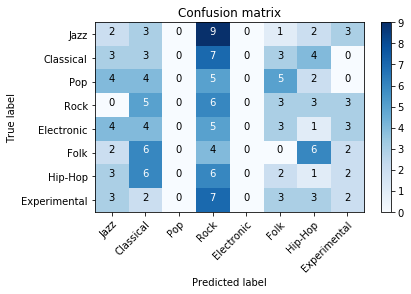

In [139]:
display_results(np.array(y_test,dtype=int), y_output.T)
plt.savefig('Classifier_single_label_parent_snn__SNN.eps', format='eps')